#### ESP32 Stereo Camera Code

In [8]:
import copy
import math

import requests

import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import torch
import torchvision
import torchvision.transforms.functional as tvtf
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights,MaskRCNN_ResNet50_FPN_V2_Weights

#this is the file with auxillary functions. stereo_image_utils.py. Should be in the same
#directory
import stereo_image_utils
from stereo_image_utils import get_detections, get_cost, draw_detections, annotate_class2 
from stereo_image_utils import get_horiz_dist_corner_tl, get_horiz_dist_corner_br, get_dist_to_centre_tl, get_dist_to_centre_br

In [16]:
image_left = cv2.imread("test_images/left.jpg")
image_right = cv2.imread("test_images/right.jpg")
AWB = True
cnt = 1

#focal length. Pre-calibrated in stereo_image_v6 notebook
fl = 2.043636363636363
tantheta = 0.7648732789907391



In [17]:
print(image_left)

[[[255 255 241]
  [254 254 242]
  [253 251 243]
  ...
  [ 77  62  43]
  [ 76  61  42]
  [ 74  59  40]]

 [[253 253 237]
  [255 254 240]
  [253 251 243]
  ...
  [ 77  62  43]
  [ 76  61  42]
  [ 74  59  40]]

 [[252 250 232]
  [253 253 237]
  [253 252 242]
  ...
  [ 78  63  44]
  [ 77  62  43]
  [ 76  61  42]]

 ...

 [[132 121  89]
  [131 120  88]
  [132 121  89]
  ...
  [102  90  66]
  [102  90  66]
  [103  91  67]]

 [[133 122  90]
  [133 122  90]
  [135 124  92]
  ...
  [102  90  66]
  [102  90  66]
  [102  90  66]]

 [[133 122  90]
  [133 122  90]
  [136 125  93]
  ...
  [102  90  66]
  [102  90  66]
  [102  90  66]]]


In [10]:
weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT

COLOURS = [
    tuple(int(colour_hex.strip('#')[i:i+2], 16) for i in (0, 2, 4))
    for colour_hex in plt.rcParams['axes.prop_cycle'].by_key()['color']
]

In [11]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights)
_ = model.eval()

In [18]:
imgs = [cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB),cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB)]

In [19]:
det, lbls, scores, masks = get_detections(model,imgs)

In [20]:
sz1 = image_right.shape[1]
centre = sz1/2
print(det)
print(np.array(weights.meta["categories"])[lbls[0]])
print(np.array(weights.meta["categories"])[lbls[1]])
cost = get_cost(det, lbls = lbls,sz1 = centre)
tracks = scipy.optimize.linear_sum_assignment(cost)

[array([[505.38153 , 213.86559 , 866.34875 , 395.91183 ],
       [  0.      , 193.12543 ,  44.464584, 239.56375 ],
       [389.8563  , 191.85622 , 404.83783 , 201.61623 ],
       [ 37.48943 , 177.40512 , 143.79688 , 264.17316 ],
       [133.50264 , 184.01927 , 185.68575 , 207.45415 ],
       [476.4581  , 190.53725 , 492.43512 , 205.66516 ],
       [436.9778  , 189.16112 , 445.99213 , 196.09471 ],
       [568.4572  , 118.15624 , 590.81903 , 127.986496],
       [626.31146 , 166.34787 , 635.0821  , 189.04134 ],
       [461.50433 , 187.3434  , 472.43808 , 196.89018 ]], dtype=float32), array([[4.61170685e+02, 2.15216553e+02, 7.90318604e+02, 3.93983002e+02],
       [3.85781677e+02, 1.91446320e+02, 4.00796051e+02, 2.01610031e+02],
       [3.21333438e-01, 1.94212570e+02, 2.33305721e+01, 2.37779968e+02],
       [1.23955841e+02, 1.83754257e+02, 1.79765121e+02, 2.07136261e+02],
       [5.59530029e+02, 1.17820358e+02, 5.82535828e+02, 1.27004745e+02],
       [4.72134552e+02, 1.90498138e+02, 4.88744

In [23]:
dists_tl =  get_horiz_dist_corner_tl(det)
dists_br =  get_horiz_dist_corner_br(det)

final_dists = []
dctl = get_dist_to_centre_tl(det[0],cntr = centre)
dcbr = get_dist_to_centre_br(det[0], cntr = centre)

for i, j in zip(*tracks):
    if dctl[i] < dcbr[i]:
        final_dists.append((dists_tl[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))

    else:
        final_dists.append((dists_br[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))

print(final_dists)

[(44.210845947265625, 'car'), (21.13401222229004, 'car'), (4.041778564453125, 'car'), (24.261367797851562, 'car'), (5.920623779296875, 'car'), (4.32354736328125, 'car'), (2.364288330078125, 'car'), (8.92718505859375, 'traffic light'), (8.109619140625, 'traffic light'), (-30.602264404296875, 'car')]


In [24]:
fl = 45
tantheta = 0.7648732789907391
           
#final distances as list
fd = [i for (i,j) in final_dists]
#find distance away
dists_away = (7.05/2)*sz1*(1/tantheta)/np.array((fd))+fl
cat_dist = []
for i in range(len(dists_away)):
    cat_dist.append(f'{np.array(weights.meta["categories"])[lbls[0]][(tracks[0][i])]} {dists_away[i]:.1f}cm')
    print(f'{np.array(weights.meta["categories"])[lbls[0]][(tracks[0][i])]} is {dists_away[i]:.1f}cm away')
print(cat_dist)

car is 136.8cm away
car is 237.1cm away
car is 1049.6cm away
car is 212.4cm away
car is 730.8cm away
car is 984.1cm away
car is 1762.3cm away
traffic light is 499.8cm away
traffic light is 545.7cm away
car is -87.7cm away
['car 136.8cm', 'car 237.1cm', 'car 1049.6cm', 'car 212.4cm', 'car 730.8cm', 'car 984.1cm', 'car 1762.3cm', 'traffic light 499.8cm', 'traffic light 545.7cm', 'car -87.7cm']


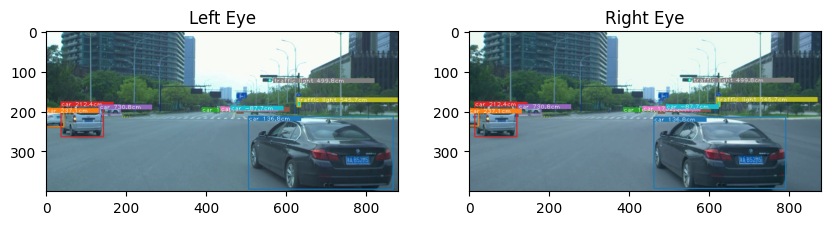

In [26]:
t1 = [list(tracks[1]), list(tracks[0])]
frames_ret = []
for i, imgi in enumerate(imgs):
    img = imgi.copy()
    deti = det[i].astype(np.int32)
    draw_detections(img,deti[list(tracks[i])], obj_order=list(t1[1]))
    annotate_class2(img,deti[list(tracks[i])],lbls[i][list(tracks[i])],cat_dist)
    frames_ret.append(img)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(frames_ret[0])
plt.title("Left Eye")

plt.subplot(122)
plt.imshow(frames_ret[1])
plt.title("Right Eye")

plt.show()
# cv2.imshow("left_eye", cv2.cvtColor(frames_ret[0],cv2.COLOR_RGB2BGR))
# cv2.imshow("right_eye", cv2.cvtColor(frames_ret[1],cv2.COLOR_RGB2BGR))